In [1]:
#|default_exp app_v2

In [2]:
#| export
from fastai.tabular.all import *

import seaborn as sns

import tqdm

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
#| export
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

#### Downloading Datasets

In [4]:
#| export
comp = 'amp-parkinsons-disease-progression-prediction'
path = setup_comp(comp, install='fastai')

#### Create Dataframes

Training Data

In [5]:
train_peptides = pd.read_csv(path/'train_peptides.csv')
train_proteins = pd.read_csv(path/'train_proteins.csv')
train_clinical_data = pd.read_csv(path/'train_clinical_data.csv')
supplemental_clinical_data = pd.read_csv(path/'supplemental_clinical_data.csv')

In [6]:
# Combine train_clinical_data and supplemental_clinical_data
combined_clinical_data = pd.concat([train_clinical_data, supplemental_clinical_data], ignore_index=True)

In [7]:
# Define categorical and continuous variable columns
cat_names = ['patient_id', 'upd23b_clinical_state_on_medication']
cont_names = ['visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']

In [8]:
# Define the preprocessing steps
procs = [Categorify, FillMissing, Normalize]

In [9]:
# Create a TabularPandas object
to = TabularPandas(combined_clinical_data, procs, cat_names, cont_names, splits=None)

In [10]:
# Apply the preprocessing steps
preprocessed_data = to.train.xs.reset_index(drop=True)

In [11]:
# Add the 'visit_id' column back to the preprocessed_data dataframe
preprocessed_data['visit_id'] = combined_clinical_data['visit_id']

In [12]:
# Check the preprocessed data
preprocessed_data.head()

,patient_id,upd23b_clinical_state_on_medication,updrs_1_na,updrs_2_na,...,updrs_2,updrs_3,updrs_4,visit_id
0,2,0,1,1,...,-0.100438,-0.433622,-0.390889,55_0
1,2,0,1,1,...,0.076453,0.285735,-0.390889,55_3
2,2,0,1,1,...,0.607123,0.933157,-0.390889,55_6
3,2,2,1,1,...,0.430233,0.645414,-0.390889,55_9
4,2,2,1,1,...,0.607123,1.436707,-0.390889,55_12


In [13]:
# Aggregate peptide data by visit_id, UniProt, and visit_month
peptide_agg = train_peptides.groupby(['visit_id', 'UniProt', 'visit_month']).agg({'PeptideAbundance': 'sum'}).reset_index()

In [14]:
# Merge aggregated peptide data with protein data
merged_protein_data = train_proteins.merge(peptide_agg, on=['visit_id', 'UniProt', 'visit_month'], how='left')

In [15]:
# Calculate the ratio of peptide abundance to NPX
merged_protein_data['Peptide_NPX_ratio'] = merged_protein_data['PeptideAbundance'] / merged_protein_data['NPX']

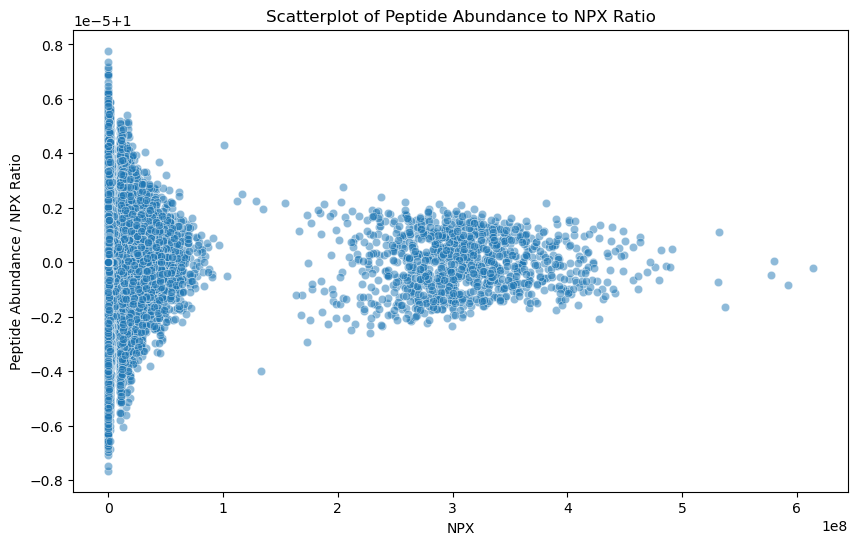

In [16]:
# Create a scatterplot of the ratio of peptide abundance to NPX
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_protein_data, x='NPX', y='Peptide_NPX_ratio', alpha=0.5)
plt.xlabel('NPX')
plt.ylabel('Peptide Abundance / NPX Ratio')
plt.title('Scatterplot of Peptide Abundance to NPX Ratio')
plt.show()

In [18]:
# Merge the protein-level data with the preprocessed clinical data
merged_data = preprocessed_data.merge(merged_protein_data, on=['visit_id'])

In [19]:
# Check the merged data
merged_data.head()

,patient_id_x,upd23b_clinical_state_on_medication,updrs_1_na,updrs_2_na,...,UniProt,NPX,PeptideAbundance,Peptide_NPX_ratio
0,2,0,1,1,...,O00391,11254.3,11254.30,1.000000
1,2,0,1,1,...,O00533,732430.0,732430.20,1.000000
2,2,0,1,1,...,O00584,39585.8,39585.80,1.000000
3,2,0,1,1,...,O14498,41526.9,41526.90,1.000000
4,2,0,1,1,...,O14773,31238.0,31238.05,1.000002


In [ ]:
import nbdev
nbdev.export.nb_export('pb_parkinsons_progression_1.ipynb', 'app_v2')
print("export successful")

In [ ]:
import re

with open('./app_v2/app_v2.py', 'r') as f:
    lines = f.readlines()

with open('./app_v2/app_v2_clean.py', 'w') as f:
    for line in lines:
        if not re.match(r'# %% ../pb_parkinsons_progression_1\.ipynb \d+', line):
            f.write(line)